<a href="https://colab.research.google.com/github/csfoxbom/Coursera_Capstone/blob/master/Week_5_capstone_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retiring at Bangkok

## 1.Install abd import library

In [3]:
!pip install geocoder

     |████████████████████████████████| 102kB 4.4MB/s 


In [99]:
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup
import requests

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
import geocoder

from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans

## 2.Get the data

In [5]:
url = 'https://en.wikipedia.org/wiki/List_of_districts_of_Bangkok'
raw = requests.get(url)
soup = BeautifulSoup(raw.content,'html.parser')
table = soup.find_all('table')
bangkok_data = pd.read_html(str(table))[0]

In [48]:
bangkok_data.head()

District(Khet)  MapNr  ...   Latitude   Longitude
0       Bang Bon     50  ...  13.659200  100.399100
1      Bang Kapi      6  ...  13.765833  100.647778
2      Bang Khae     40  ...  13.696111  100.409444
3      Bang Khen      5  ...  13.873889  100.596389
4  Bang Kho Laem     31  ...  13.693333  100.502500

[5 rows x 8 columns]

In [41]:
# set api key
CLIENT_ID = 'QVHMKFRYRHWMG2PYYT0ZMKE1TKJIPU4YQC0UGLXXLBLLY1GM' # your Foursquare ID
CLIENT_SECRET = 'Q3X4DEWYV2ERJ3FKU10W5IQNPJGMUBVKC34EMLNIPNGUNJ3R' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
radius = 500
LIMIT = 100

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    13.78,
    100.542778, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=QVHMKFRYRHWMG2PYYT0ZMKE1TKJIPU4YQC0UGLXXLBLLY1GM&client_secret=Q3X4DEWYV2ERJ3FKU10W5IQNPJGMUBVKC34EMLNIPNGUNJ3R&v=20180605&ll=13.78,100.542778&radius=500&limit=100'

In [42]:
# try to see result
result = requests.get(url).json()
result

{'meta': {'code': 200, 'requestId': '605f45d148d83d2b059985eb'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-543801e0498e0fa6d1f70ad0-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_',
          'suffix': '.png'},
         'id': '4bf58dd8d48988d116941735',
         'name': 'Bar',
         'pluralName': 'Bars',
         'primary': True,
         'shortName': 'Bar'}],
       'id': '543801e0498e0fa6d1f70ad0',
       'location': {'address': '18/1 Soi Ari 1',
        'cc': 'TH',
        'city': 'พญาไท',
        'country': 'ประเทศไทย',
        'distance': 103,
        'formattedAddress': ['18/1 Soi Ari 1',
         'พญาไท',
         'กรุงเทพมหานคร 10400',
         'ประเทศไทย'],
        'labeledLatLngs': [{'label': 'display',
          'lat': 13.77987985694022

## 3.Explore the area

In [54]:
bangkok_map = folium.Map(location=[13.78,100.542778],zoom_start=11,height=600,width=800)
for lat,lng,name in zip(bangkok_data['Latitude'],bangkok_data['Longitude'],bangkok_data['District(Khet)']):
  folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        popup=name,
        parse_html=False).add_to(bangkok_map)  
    
bangkok_map

In [22]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [43]:
venues = result['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

name           categories        lat         lng
0   O'glee (โอ-กลี)                  Bar  13.779880  100.543729
1      ส้มตำป้าแต๋ม   Som Tum Restaurant  13.781047  100.544210
2      Hero Izakaya  Japanese Restaurant  13.781721  100.543566
3       Coffee No.9          Coffee Shop  13.780003  100.543816
4  Sousaku (โซซาคุ)     Sushi Restaurant  13.780215  100.540466

In [38]:
nearby_venues.to_csv('venue2.csv')

In [51]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [52]:
# get venue data from neighborhood
nearby_venues = getNearbyVenues(bangkok_data['District(Khet)'],bangkok_data['Latitude'],bangkok_data['Longitude'])
nearby_venues.shape

(2904, 7)

In [53]:
nearby_venues.head()

Neighborhood  Neighborhood Latitude  ...  Venue Longitude       Venue Category
0     Bang Bon                13.6592  ...       100.395230      Thai Restaurant
1     Bang Bon                13.6592  ...       100.401403  Japanese Restaurant
2     Bang Bon                13.6592  ...       100.405054        Garden Center
3     Bang Bon                13.6592  ...       100.405323         Noodle House
4     Bang Bon                13.6592  ...       100.397243    Convenience Store

[5 rows x 7 columns]

In [56]:
# Display Venue of Bangkok
vanue_map = folium.Map(location=[13.78,100.542778],zoom_start=11,height=600,width=800)
for lat,lng,name in zip(nearby_venues['Venue Latitude'],nearby_venues['Venue Longitude'],nearby_venues['Venue']):
  folium.CircleMarker(
        [lat, lng],
        radius=1,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.2,
        popup=name,
        parse_html=False).add_to(vanue_map)  
    
vanue_map

## 4. Clustering approach
Preparing the data.

In [62]:
# turn into binary class data with onehot encoding

bangkok_onehot = pd.get_dummies(nearby_venues[['Venue Category']],prefix="",prefix_sep="")

bangkok_onehot['Neighborhood'] = nearby_venues['Neighborhood'] 

print('Shape of onhot data is',bangkok_onehot.shape)

(2904, 233)

In [104]:
before_cluster = bangkok_onehot.groupby('Neighborhood').mean().reset_index()

before_cluster['Population(M)'] = bangkok_data['Popu-lation']/1000000

In [105]:
to_cluster = before_cluster.drop('Neighborhood',axis=1)
to_cluster.head()

Accessories Store  African Restaurant  ...  Zoo Exhibit  Population(M)
0                0.0                 0.0  ...          0.0       0.105161
1                0.0                 0.0  ...          0.0       0.148465
2                0.0                 0.0  ...          0.0       0.191781
3                0.0                 0.0  ...          0.0       0.189539
4                0.0                 0.0  ...          0.0       0.094956

[5 rows x 233 columns]

## Clustering data with Kmeans
create find the best K function

In [90]:
def find_best_KMeans(input_df,n_k):
  elb = []
  kmax = n_k
  for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(input_df)
    #labels = kmeans.labels_
    elb.append(kmeans.inertia_)
  return elb

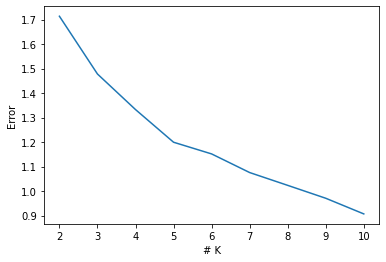

In [95]:
k_value = find_best_KMeans(to_cluster,10)
plt.plot(range(2,11),k_value)
plt.ylabel('Error')
plt.xlabel('# K')
plt.show()

The best K is 5.

In [110]:
kmeans = KMeans(n_clusters = 5).fit(to_cluster)
labels = kmeans.labels_


In [97]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [121]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']
for_sorting = before_cluster.drop('Population(M)',axis=1)
# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = for_sorting['Neighborhood']

for ind in np.arange(for_sorting.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(for_sorting.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood  ... 10th Most Common Venue
0       Bang Bon  ...    Japanese Restaurant
1      Bang Kapi  ...      Convenience Store
2      Bang Khae  ...       Asian Restaurant
3      Bang Khen  ...     Som Tum Restaurant
4  Bang Kho Laem  ...   Fast Food Restaurant

[5 rows x 11 columns]

In [125]:
# insert labels
neighborhoods_venues_sorted.drop('Cluster Labels',axis=1,inplace=True)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', labels)
finale_data = pd.concat([neighborhoods_venues_sorted,bangkok_data[['Popu-lation','Latitude','Longitude']]],axis=1)
finale_data

Cluster Labels          Neighborhood  ...   Latitude   Longitude
0                4              Bang Bon  ...  13.659200  100.399100
1                0             Bang Kapi  ...  13.765833  100.647778
2                4             Bang Khae  ...  13.696111  100.409444
3                0             Bang Khen  ...  13.873889  100.596389
4                4         Bang Kho Laem  ...  13.693333  100.502500
5                0       Bang Khun Thian  ...  13.660833  100.435833
6                2               Bang Na  ...  13.680081  100.591800
7                0            Bang Phlat  ...  13.793889  100.505000
8                2              Bang Rak  ...  13.730833  100.524167
9                1              Bang Sue  ...  13.809722  100.537222
10               1           Bangkok Noi  ...  13.770867  100.467933
11               1           Bangkok Yai  ...  13.722778  100.476389
12               4             Bueng Kum  ...  13.785278  100.669167
13               0             Chatuchak  ...  13.828611  100.559722
14               2            Chom Thong  ...  13.677222  100.484722
15               4             Din Daeng  ...  13.769722  100.552778
16               4            Don Mueang  ...  13.913611  100.589722
17               1                 Dusit  ...  13.776944  100.520556
18               2           Huai Khwang  ...  13.776667  100.579444
19               0           Khan Na Yao  ...  13.827100  100.674300
20               0         Khlong Sam Wa  ...  13.859722  100.704167
21               2            Khlong San  ...  13.730278  100.509722
22               4           Khlong Toei  ...  13.708056  100.583889
23               0                Lak Si  ...  13.887500  100.578889
24               2           Lat Krabang  ...  13.722317  100.759669
25               0             Lat Phrao  ...  13.803611  100.607500
26               3              Min Buri  ...  13.813889  100.748056
27               0             Nong Chok  ...  13.855556  100.862500
28               4            Nong Khaem  ...  13.704722  100.348889
29               2            Pathum Wan  ...  13.744942  100.522200
30               0         Phasi Charoen  ...  13.714722  100.437222
31               2            Phaya Thai  ...  13.780000  100.542778
32               4          Phra Khanong  ...  13.702222  100.601667
33               2           Phra Nakhon  ...  13.764444  100.499167
34               2  Pom Prap Sattru Phai  ...  13.758056  100.513056
35               4                Prawet  ...  13.716944  100.694444
36               0            Rat Burana  ...  13.682222  100.505556
37               2           Ratchathewi  ...  13.758889  100.534444
38               4               Sai Mai  ...  13.919167  100.645833
39               2        Samphanthawong  ...  13.731389  100.514167
40               2           Saphan Sung  ...  13.770000  100.684722
41               1                Sathon  ...  13.708056  100.526389
42               1            Suan Luang  ...  13.730278  100.651389
43               4           Taling Chan  ...  13.776944  100.456667
44               4        Thawi Watthana  ...  13.787800  100.363800
45               1             Thon Buri  ...  13.725000  100.485833
46               4            Thung Khru  ...  13.647200  100.495800
47               0        Wang Thonglang  ...  13.786400  100.608700
48               2              Watthana  ...  13.742222  100.585833
49               0              Yan Nawa  ...  13.696944  100.543056

[50 rows x 15 columns]

In [119]:
map_clusters = folium.Map(location=[13.78,100.542778], zoom_start=11,width=800,height=600)

# set color scheme for the clusters
x = np.arange(5)
ys = [i + x + (i*x)**2 for i in range(5)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(finale_data['Latitude'], finale_data['Longitude'], finale_data['Neighborhood'], finale_data['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius = 10,
        popup = label,
        color = rainbow[cluster-1],
        fill = True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [126]:
finale_data[finale_data['Cluster Labels'] == 0]

Cluster Labels     Neighborhood  ...   Latitude   Longitude
1                0        Bang Kapi  ...  13.765833  100.647778
3                0        Bang Khen  ...  13.873889  100.596389
5                0  Bang Khun Thian  ...  13.660833  100.435833
7                0       Bang Phlat  ...  13.793889  100.505000
13               0        Chatuchak  ...  13.828611  100.559722
19               0      Khan Na Yao  ...  13.827100  100.674300
20               0    Khlong Sam Wa  ...  13.859722  100.704167
23               0           Lak Si  ...  13.887500  100.578889
25               0        Lat Phrao  ...  13.803611  100.607500
27               0        Nong Chok  ...  13.855556  100.862500
30               0    Phasi Charoen  ...  13.714722  100.437222
36               0       Rat Burana  ...  13.682222  100.505556
47               0   Wang Thonglang  ...  13.786400  100.608700
49               0         Yan Nawa  ...  13.696944  100.543056

[14 rows x 15 columns]

In [127]:
finale_data[finale_data['Cluster Labels']==1]

Cluster Labels Neighborhood  ...   Latitude   Longitude
9                1     Bang Sue  ...  13.809722  100.537222
10               1  Bangkok Noi  ...  13.770867  100.467933
11               1  Bangkok Yai  ...  13.722778  100.476389
17               1        Dusit  ...  13.776944  100.520556
41               1       Sathon  ...  13.708056  100.526389
42               1   Suan Luang  ...  13.730278  100.651389
45               1    Thon Buri  ...  13.725000  100.485833

[7 rows x 15 columns]

In [128]:
finale_data[finale_data['Cluster Labels']==2]

Cluster Labels          Neighborhood  ...   Latitude   Longitude
6                2               Bang Na  ...  13.680081  100.591800
8                2              Bang Rak  ...  13.730833  100.524167
14               2            Chom Thong  ...  13.677222  100.484722
18               2           Huai Khwang  ...  13.776667  100.579444
21               2            Khlong San  ...  13.730278  100.509722
24               2           Lat Krabang  ...  13.722317  100.759669
29               2            Pathum Wan  ...  13.744942  100.522200
31               2            Phaya Thai  ...  13.780000  100.542778
33               2           Phra Nakhon  ...  13.764444  100.499167
34               2  Pom Prap Sattru Phai  ...  13.758056  100.513056
37               2           Ratchathewi  ...  13.758889  100.534444
39               2        Samphanthawong  ...  13.731389  100.514167
40               2           Saphan Sung  ...  13.770000  100.684722
48               2              Watthana  ...  13.742222  100.585833

[14 rows x 15 columns]

In [129]:
finale_data[finale_data['Cluster Labels']==3]

Cluster Labels Neighborhood  ...   Latitude   Longitude
26               3     Min Buri  ...  13.813889  100.748056

[1 rows x 15 columns]

In [130]:
finale_data[finale_data['Cluster Labels']==4]

Cluster Labels    Neighborhood  ...   Latitude   Longitude
0                4        Bang Bon  ...  13.659200  100.399100
2                4       Bang Khae  ...  13.696111  100.409444
4                4   Bang Kho Laem  ...  13.693333  100.502500
12               4       Bueng Kum  ...  13.785278  100.669167
15               4       Din Daeng  ...  13.769722  100.552778
16               4      Don Mueang  ...  13.913611  100.589722
22               4     Khlong Toei  ...  13.708056  100.583889
28               4      Nong Khaem  ...  13.704722  100.348889
32               4    Phra Khanong  ...  13.702222  100.601667
35               4          Prawet  ...  13.716944  100.694444
38               4         Sai Mai  ...  13.919167  100.645833
43               4     Taling Chan  ...  13.776944  100.456667
44               4  Thawi Watthana  ...  13.787800  100.363800
46               4      Thung Khru  ...  13.647200  100.495800

[14 rows x 15 columns]

Conclusion: Using k-means clustering algorithm, separated the neighborhood into 5 different clusters and for 50 different district from dataset, I never know before that my country have a ton of Noodle House. Mostly of each cluster appear to has restaurant except cluster 3rd, it's seem to be more transportation.